In [ ]:
!pip install bs4
!pip install requests
!pip install html5lib
!python -m spacy download en_core_web_md
!pip install catboost
!pip install -U nltk

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=58c50e192390192441fe69194fdbfcb865d0d5af671b4ee50e0c6a8a96b20823
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4
2023-09-14 17:55:37.840776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 17:55:40.346807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 18.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s 

# Импортирование необходимых библиотек

In [ ]:
from bs4 import BeautifulSoup
import requests
import re
import time
import numpy as np
import pandas as pd
from numba import njit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

import seaborn as sns
import plotly.express as pe
import matplotlib.pyplot as plt

from spacy import glossary
import joblib
import string
import spacy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Описание предметной области

Сайт, с которого будет производиться считывание текста, содержит отзывы о носках с изображением собак. Отзывы содержат оценку и само высказывание покупателя о товаре.

# Предобработка данных

## Считывание отзывов и их рейтингов с первой страницы сайта для предпросмотра

In [ ]:
response = requests.get("https://www.trustpilot.com/review/gopupsocks.com")
soup = BeautifulSoup(response.text, "html.parser")
review_elements = soup.find_all("div", class_="styles_reviewContent__0Q2Tg")
ratings_1 = [rating.get('data-service-review-rating') for rating in soup.find_all("div", class_="styles_reviewHeader__iU9Px")]
dates_1 = []
for review in review_elements:
  cur_date = str(*re.findall("Date\sof\sexperience:\s\w+\s\d{2},\s\d{4}",review.get_text())).split()
  cur_month = cur_date[3]
  cur_year = cur_date[5]
  dates_1.append((cur_month, cur_year))
reviews_1 = [review.get_text() for review in review_elements]

In [ ]:
print(reviews_1)

["DO NOTWell I haven't received my items yet. A shipping label was created a few days ago but the package hasn't shipped and doesn't say when it'll arrive. Feels like you rushed thru the order process but didn't actually ship anything.Date of experience: June 29, 2023", 'Not goodI liked how the products in this shop look, but you need to do something when your delivery and service. And I think prices are pretty high, especially for the socks.Date of experience: June 15, 2023', "I've ordered my socks in NovemberI've ordered my socks in November. I writed many mail untill now (we are in june) the continue to write that my suck will arrive, I have asked my money back and nobody answer to me.Date of experience: June 09, 2023", 'I bought these for my Fiance she…I bought these for my Fiance she absolutely loves them. Honestly I bought them just for the "cute" factor, but she swears they\'re actually really comfortable. Another aspect of these that impressed me was that the clarity of my dogs

In [ ]:
dates_1

[('June', '2023'),
 ('June', '2023'),
 ('June', '2023'),
 ('May', '2022'),
 ('June', '2022'),
 ('June', '2022'),
 ('October', '2022'),
 ('June', '2022'),
 ('December', '2022'),
 ('May', '2022'),
 ('June', '2022'),
 ('December', '2022'),
 ('June', '2022'),
 ('November', '2022'),
 ('December', '2022'),
 ('December', '2022'),
 ('June', '2022'),
 ('May', '2022'),
 ('January', '2023'),
 ('November', '2022')]

## Структурированное отображение скрипта сайта

In [ ]:
print(soup.prettify())

<!DOCTYPE html>
<html lang="en-US">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <link href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="/manifest.json" rel="manifest"/>
  <meta content="Trustpilot" name="application-name"/>
  <meta content="#1c1c1c" name="theme-color"/>
  <link href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/>
  <link href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/>
  <link href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/>
  <link color="#00b67a" href="https://cdn.trustpilot.net/brand-assets/1.9.0/favicons/safari-pinned-tab.svg" rel="mask-icon"/>
  <meta content="Trustpilot" name="apple-mobile-web-app-title"/

In [ ]:
tag_object=soup.title
print("tag object:",tag_object)

tag object: <title>GoPupSocks Reviews | Read Customer Service Reviews of gopupsocks.com</title>


In [ ]:
len(ratings_1) # number of reviews on each page

20

In [ ]:
len(dates_1)

20

In [ ]:
# reviews_with_ratings = list(zip(review_ratings, reviews))
# reviews_with_ratings

## Функция считывания каждой страницы сайта

In [ ]:
%%time
def process_pages():
    reviews_through_pages = []
    ratings_through_pages = []
    dates_through_pages = []
    for page_number in range(2, 1200):
        print(f"Processing page number: {page_number} out of 1200")
        response = requests.get(f"https://www.trustpilot.com/review/gopupsocks.com?page={page_number}")
        soup = BeautifulSoup(response.text, "html.parser")
        review_elements = soup.find_all("div", class_="styles_reviewContent__0Q2Tg")
        ratings = [rating.get('data-service-review-rating') for rating in soup.find_all("div", class_="styles_reviewHeader__iU9Px")]
        page_review = [review.get_text() for review in review_elements]
        dates_cur = []
        for review in review_elements:
            cur_date = str(*re.findall("Date\sof\sexperience:\s\w+\s\d{2},\s\d{4}",review.get_text())).split()
            cur_month = cur_date[3]
            cur_year = cur_date[5]
            dates_cur.append((cur_month, cur_year))
        reviews_through_pages = reviews_through_pages + page_review
        ratings_through_pages = ratings_through_pages + ratings
        dates_through_pages = dates_through_pages + dates_cur
    return reviews_through_pages, ratings_through_pages, dates_through_pages

reviews_through_pages, ratings_through_pages, dates_through_pages = process_pages()
general_reviews = reviews_1 + reviews_through_pages # объединение данных с первой страницей
general_ratings = ratings_1 + ratings_through_pages
general_dates = dates_1 + dates_through_pages

Processing page number: 2 out of 1200
Processing page number: 3 out of 1200
Processing page number: 4 out of 1200
Processing page number: 5 out of 1200
Processing page number: 6 out of 1200
Processing page number: 7 out of 1200
Processing page number: 8 out of 1200
Processing page number: 9 out of 1200
Processing page number: 10 out of 1200
Processing page number: 11 out of 1200
Processing page number: 12 out of 1200
Processing page number: 13 out of 1200
Processing page number: 14 out of 1200
Processing page number: 15 out of 1200
Processing page number: 16 out of 1200
Processing page number: 17 out of 1200
Processing page number: 18 out of 1200
Processing page number: 19 out of 1200
Processing page number: 20 out of 1200
Processing page number: 21 out of 1200
Processing page number: 22 out of 1200
Processing page number: 23 out of 1200
Processing page number: 24 out of 1200
Processing page number: 25 out of 1200
Processing page number: 26 out of 1200
Processing page number: 27 out of

## Количество извлеченных отзывов

при каждом новом запуске парсинга разное кол-во отзывов

In [ ]:
len(general_reviews)

6020

In [ ]:
len(general_ratings)

6020

Создание словаря частот появления каждого рейтинга

In [ ]:
rating_frequency = {k:general_ratings.count(k) for k in general_ratings}
rating_frequency

{'2': 567, '1': 2905, '5': 1750, '3': 457, '4': 341}

Представление распределения рейтингов в качестве PieChart

In [ ]:
data = {'Rating': rating_frequency.keys(), 'Count': rating_frequency.values()}
fig = pe.pie(data, values='Count', names='Rating', title='Distribution of Ratings')
fig.show()

Исходя из диаграммы можно отметить, что присутствует дисбаланс классов, который в дальнейшем предстоит устранить

## Статистическая характеристика отзывов по датам

In [ ]:
from collections import defaultdict
from datetime import datetime

ratings_through_dates = list(zip(general_ratings, general_dates))

ratings = [[5, ('June', 2021)], [4, ('April', 2023)], [3, ('June', 2021)], [2, ('April', 2023)]]
rating_counts = defaultdict(int)

for rating, (month, year) in ratings_through_dates:
    date = datetime.strptime(f"{month} {year}", "%B %Y")
    year = date.year
    month = date.strftime("%B")
    rating_counts[(year, month)] += 1

for (year, month), count in rating_counts.items():
    print(f"{month} {year}: {count} ratings")

June 2023: 3 ratings
May 2022: 67 ratings
June 2022: 43 ratings
October 2022: 1 ratings
December 2022: 17 ratings
November 2022: 2 ratings
January 2023: 3 ratings
July 2022: 28 ratings
February 2023: 1 ratings
September 2022: 6 ratings
April 2022: 38 ratings
August 2022: 7 ratings
April 2023: 1 ratings
January 2022: 2264 ratings
November 2021: 1 ratings
March 2022: 65 ratings
February 2022: 151 ratings
December 2021: 3322 ratings


In [ ]:
years = [item[0][0] for item in rating_counts.items()]
counts = [item[1] for item in rating_counts.items()]

In [ ]:
df = pd.DataFrame(list(rating_counts.items()), columns=['Dates', 'Count'])
df

,Dates,Count
0,"(2023, June)",3
1,"(2022, May)",67
2,"(2022, June)",43
3,"(2022, October)",1
4,"(2022, December)",17
5,"(2022, November)",2
6,"(2023, January)",3
7,"(2022, July)",28
8,"(2023, February)",1
9,"(2022, September)",6


In [ ]:
data = {'Rating': rating_counts.keys(), 'Count': rating_counts.values()}
fig = pe.pie(data, values='Count', names='Rating', title='Distribution of Ratings')
fig.update_layout(title='Rating Counts by Dates')
fig.show()

Исходя из этой диаграммы можно сделать вывод, что в моей предметной области больше всего отзывов было написано в декабре 2021 и в январе 2022. Можно предположить, что в то время была успешная пиар-кампания или просто в то время товар был наиболее популярным на рынке.

Подгрузка языкового пакета для лемматизации и стоп-слов

In [ ]:
nlp = spacy.load('en_core_web_md')
stopWords = set(stopwords.words('english'))

Словарь для определения частей речи

In [37]:
glossary.GLOSSARY

{'ADJ': 'adjective',
 'ADP': 'adposition',
 'ADV': 'adverb',
 'AUX': 'auxiliary',
 'CONJ': 'conjunction',
 'CCONJ': 'coordinating conjunction',
 'DET': 'determiner',
 'INTJ': 'interjection',
 'NOUN': 'noun',
 'NUM': 'numeral',
 'PART': 'particle',
 'PRON': 'pronoun',
 'PROPN': 'proper noun',
 'PUNCT': 'punctuation',
 'SCONJ': 'subordinating conjunction',
 'SYM': 'symbol',
 'VERB': 'verb',
 'X': 'other',
 'EOL': 'end of line',
 'SPACE': 'space',
 '.': 'punctuation mark, sentence closer',
 ',': 'punctuation mark, comma',
 '-LRB-': 'left round bracket',
 '-RRB-': 'right round bracket',
 '``': 'opening quotation mark',
 '""': 'closing quotation mark',
 "''": 'closing quotation mark',
 ':': 'punctuation mark, colon or ellipsis',
 '$': 'symbol, currency',
 '#': 'symbol, number sign',
 'AFX': 'affix',
 'CC': 'conjunction, coordinating',
 'CD': 'cardinal number',
 'DT': 'determiner',
 'EX': 'existential there',
 'FW': 'foreign word',
 'HYPH': 'punctuation mark, hyphen',
 'IN': 'conjunction, su

## Функция препроцессинга отзывов

В ходе преобразования производится приведение текста к нижнему регистру и разбиение его на токены, извлекаются значимые слова и с помощью регулярных выражений удаляется дата написания отзыва и повторное разделение на слова.

In [ ]:
def preprocessed(review_text):
    # print(f"Processing review: {review_text.}")
    tokens = word_tokenize(review_text.lower())
    valuable_words = [word for word in tokens if len(word)>1 and word not in stopWords and word not in string.punctuation]
    spacy_results = nlp(' '.join(valuable_words))
    lemmatized = [word.lemma_ for word in spacy_results if word.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'PROPN']] #
    output = re.sub("\W+"," ", re.sub("/date\sof\sexperience:\s\w+\s\d{2},\s\d{4}/gm","",' '.join(lemmatized))).split() # [[:punct:]]
    return output

In [ ]:
%%time
tokenized = []
for each in general_reviews:
    tokenized.append(preprocessed(each))
tokenized

CPU times: user 1min 15s, sys: 146 ms, total: 1min 15s
Wall time: 1min 15s


[['notwell',
  'receive',
  'item',
  'shipping',
  'label',
  'create',
  'day',
  'ago',
  'package',
  'ship',
  'say',
  'arrive',
  'feel',
  'rush',
  'order',
  'process',
  'actually',
  'ship',
  'anything',
  'date',
  'experience',
  'june'],
 ['goodi',
  'like',
  'product',
  'shop',
  'look',
  'need',
  'something',
  'delivery',
  'service',
  'think',
  'price',
  'pretty',
  'high',
  'especially',
  'socks',
  'date',
  'experience',
  'june'],
 ['order',
  'sock',
  'novemberi',
  'order',
  'sock',
  'november',
  'write',
  'many',
  'mail',
  'june',
  'continue',
  'write',
  'suck',
  'arrive',
  'ask',
  'money',
  'back',
  'nobody',
  'answer',
  'me',
  'date',
  'experience',
  'june'],
 ['buy',
  'fiance',
  'she',
  'I',
  'buy',
  'fiance',
  'absolutely',
  'honestly',
  'buy',
  'cute',
  'factor',
  'swear',
  'actually',
  'really',
  'comfortable',
  'aspect',
  'impress',
  'clarity',
  'dog',
  'face',
  'actually',
  'tailor',
  'design',
  'cle

Список отформатированных слов, соединенные пробелами

In [ ]:
corpus = [' '.join(review) for review in tokenized]
corpus

['notwell receive item shipping label create day ago package ship say arrive feel rush order process actually ship anything date experience june',
 'goodi like product shop look need something delivery service think price pretty high especially socks date experience june',
 'order sock novemberi order sock november write many mail june continue write suck arrive ask money back nobody answer me date experience june',
 'buy fiance she I buy fiance absolutely honestly buy cute factor swear actually really comfortable aspect impress clarity dog face actually tailor design clear worn date experience',
 'product absolutely exceed my product absolutely exceed expectation photo send dog good possible one capture take send create pair sock completely fantastic thank enough excellent work complement galore date experience june',
 'impressed extremely satisfiedproduction shipment take much long anticipate luckily place order way ahead time pair make husband dog father day extremely impress satisf

# Метод векторизации текстов TF-IDF

Использование метода синтетической передискретизации меньшинства `SMOTE`, который сгенерирует синтетические данные для классов с наименьшим количеством элементов на основе существующих данных.

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(general_reviews)

smote = SMOTE(random_state=42)
X_train_resampled, labels_resampled = smote.fit_resample(X_train_tfidf, general_ratings)

joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

Сохранение объекта-векторизатора после сопоставления с обучающими данными, чтобы впоследствии его можно было использовать для векторизации новых данных.

In [ ]:
X_train_resampled.shape

(14525, 8551)

`OHE` рассматривался как вариант преобразования текстовых данных в числовые признаки, но в итоге не был использован по причине слишком большого в результате количества фичей.

In [ ]:
encoder = OneHotEncoder()

encoded_reviews = []
for review in tokenized:
    encoded_review = encoder.fit_transform([[word] for word in review]).toarray()
    encoded_reviews.append(encoded_review.tolist())

# Обучение модели

## Деление датасета на обучающую и валидационную выборки

In [ ]:
train_features, test_features, train_target, test_target = train_test_split(X_train_tfidf, general_ratings, test_size=0.25, random_state=42)

In [ ]:
train_features_tfidf, test_features_tfidf, train_target_tfidf, test_target_tfidf = train_test_split(X_train_resampled, labels_resampled, test_size=0.25, random_state=42)

## Logistic Regression (базовая)

In [ ]:
tic = time.time()
model_lr = LogisticRegression(random_state = 42)
lr = model_lr.fit(train_features,train_target)
target_predicted = lr.predict(test_features)
lr_acc = accuracy_score(test_target,target_predicted)
toc = time.time()
lr_time = toc-tic
print(f'Accuracy: {lr_acc}\nExecution time: {lr_time}')

Accuracy: 0.7926910299003322
Execution time: 2.5799028873443604


In [ ]:
print(classification_report(test_target,target_predicted))

              precision    recall  f1-score   support

           1       0.82      0.98      0.89       749
           2       0.27      0.11      0.15       120
           3       0.55      0.24      0.34       116
           4       0.50      0.09      0.16        86
           5       0.83      0.95      0.89       434

    accuracy                           0.79      1505
   macro avg       0.59      0.47      0.48      1505
weighted avg       0.74      0.79      0.75      1505



Можно наблюдать, что класс с рейтингом 2 (плохо) определяется хуже всех, в то время как 1 (очень плохо) и 5 (отлично) показывают хорошие результаты

## Logistic Regression (на сбалансированных классах)

In [ ]:
tic = time.time()
model_lr = LogisticRegression(random_state = 42)
lr = model_lr.fit(train_features_tfidf,train_target_tfidf)
target_predicted_tfidf = lr.predict(test_features_tfidf)
lr_acc_res = accuracy_score(test_target_tfidf,target_predicted_tfidf)
toc = time.time()
lr_tfidf_time = toc-tic
print(f'Accuracy: {lr_acc_res}\nExecution time: {lr_tfidf_time}')

Accuracy: 0.9008810572687225
Execution time: 4.387600660324097


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
print(classification_report(test_target_tfidf,target_predicted_tfidf))

              precision    recall  f1-score   support

           1       0.89      0.80      0.84       717
           2       0.85      0.90      0.88       742
           3       0.91      0.93      0.92       736
           4       0.90      0.96      0.93       705
           5       0.95      0.92      0.93       732

    accuracy                           0.90      3632
   macro avg       0.90      0.90      0.90      3632
weighted avg       0.90      0.90      0.90      3632



## CatBoostClassifier

In [38]:
tic = time.time()
model_cb = CatBoostClassifier(random_state = 42)
cb = model_cb.fit(train_features,train_target)
target_predicted = cb.predict(test_features)
cb_acc = accuracy_score(test_target,target_predicted)
toc = time.time()
cb_time = toc-tic
print(f'Accuracy: {cb_acc}\nExecution time: {cb_time}')

Learning rate set to 0.08545
0:	learn: 1.5091238	total: 3.51s	remaining: 58m 30s
1:	learn: 1.4299578	total: 5.81s	remaining: 48m 18s
2:	learn: 1.3610418	total: 6.89s	remaining: 38m 11s
3:	learn: 1.3032931	total: 8.15s	remaining: 33m 50s
4:	learn: 1.2567850	total: 9.59s	remaining: 31m 48s
5:	learn: 1.2186862	total: 10.9s	remaining: 29m 58s
6:	learn: 1.1879814	total: 12.2s	remaining: 28m 52s
7:	learn: 1.1552596	total: 13.4s	remaining: 27m 44s
8:	learn: 1.1260534	total: 14.8s	remaining: 27m 6s
9:	learn: 1.0998711	total: 15.9s	remaining: 26m 13s
10:	learn: 1.0736619	total: 18s	remaining: 27m
11:	learn: 1.0554243	total: 20.8s	remaining: 28m 29s
12:	learn: 1.0374295	total: 22.5s	remaining: 28m 30s
13:	learn: 1.0219302	total: 24.4s	remaining: 28m 38s
14:	learn: 1.0054839	total: 26.2s	remaining: 28m 41s
15:	learn: 0.9949124	total: 27.3s	remaining: 27m 56s
16:	learn: 0.9823083	total: 28.3s	remaining: 27m 14s
17:	learn: 0.9708956	total: 29.5s	remaining: 26m 48s
18:	learn: 0.9592313	total: 31.6s	

In [39]:
print(classification_report(test_target,target_predicted))

              precision    recall  f1-score   support

           1       0.81      0.95      0.88       749
           2       0.29      0.10      0.15       120
           3       0.44      0.24      0.31       116
           4       0.44      0.17      0.25        86
           5       0.82      0.92      0.87       434

    accuracy                           0.78      1505
   macro avg       0.56      0.48      0.49      1505
weighted avg       0.72      0.78      0.74      1505



## Балансированный 😽

In [40]:
tic = time.time()
model_cb = CatBoostClassifier(random_state = 42)
cb = model_cb.fit(train_features_tfidf,train_target_tfidf)
target_predicted_tfidf = cb.predict(test_features_tfidf)
cb_acc_res = accuracy_score(test_target_tfidf,target_predicted_tfidf)
toc = time.time()
cb_tfidf_time = toc - tic
print(f'Accuracy: {cb_acc_res}\nExecution time: {cb_tfidf_time}')

Learning rate set to 0.089375
0:	learn: 1.5392200	total: 1.63s	remaining: 27m 8s
1:	learn: 1.4820785	total: 2.79s	remaining: 23m 11s
2:	learn: 1.4311986	total: 3.87s	remaining: 21m 25s
3:	learn: 1.3882718	total: 4.94s	remaining: 20m 30s
4:	learn: 1.3538056	total: 5.99s	remaining: 19m 51s
5:	learn: 1.3267154	total: 7.15s	remaining: 19m 44s
6:	learn: 1.2965615	total: 8.91s	remaining: 21m 4s
7:	learn: 1.2747470	total: 10.5s	remaining: 21m 44s
8:	learn: 1.2512435	total: 11.7s	remaining: 21m 26s
9:	learn: 1.2289302	total: 12.7s	remaining: 21m 2s
10:	learn: 1.2069564	total: 13.8s	remaining: 20m 42s
11:	learn: 1.1923714	total: 14.8s	remaining: 20m 22s
12:	learn: 1.1765964	total: 15.9s	remaining: 20m 4s
13:	learn: 1.1611264	total: 16.9s	remaining: 19m 52s
14:	learn: 1.1460194	total: 18.1s	remaining: 19m 45s
15:	learn: 1.1340067	total: 19.1s	remaining: 19m 36s
16:	learn: 1.1210359	total: 20.3s	remaining: 19m 33s
17:	learn: 1.1110147	total: 22.3s	remaining: 20m 14s
18:	learn: 1.0980179	total: 23

In [41]:
print(classification_report(test_target_tfidf,target_predicted_tfidf))

              precision    recall  f1-score   support

           1       0.85      0.86      0.85       717
           2       0.90      0.87      0.88       742
           3       0.92      0.92      0.92       736
           4       0.91      0.90      0.90       705
           5       0.88      0.91      0.90       732

    accuracy                           0.89      3632
   macro avg       0.89      0.89      0.89      3632
weighted avg       0.89      0.89      0.89      3632



## GradientBoostingClassifier

In [42]:
tic = time.time()
model_gb = GradientBoostingClassifier(random_state = 42)
gb = model_gb.fit(train_features,train_target)
target_predicted = gb.predict(test_features)
gb_acc = accuracy_score(test_target,target_predicted)
toc = time.time()
gb_time = toc-tic
print(f'Accuracy: {gb_acc}\nExecution time: {gb_time}')

Accuracy: 0.7634551495016612
Execution time: 55.598485469818115


In [43]:
print(classification_report(test_target,target_predicted))

              precision    recall  f1-score   support

           1       0.80      0.96      0.87       749
           2       0.26      0.12      0.17       120
           3       0.44      0.20      0.27       116
           4       0.31      0.09      0.14        86
           5       0.81      0.89      0.85       434

    accuracy                           0.76      1505
   macro avg       0.52      0.45      0.46      1505
weighted avg       0.71      0.76      0.72      1505



## Сбалансированный GradientBoostingClassifier

In [48]:
tic = time.time()
model_gb = GradientBoostingClassifier(random_state = 42)
gb = model_gb.fit(train_features_tfidf,train_target_tfidf)
target_predicted_tfidf = gb.predict(test_features_tfidf)
gb_acc_res = accuracy_score(test_target_tfidf,target_predicted_tfidf)
toc = time.time()
gb_tfidf_time = toc-tic
print(f'Accuracy: {gb_acc_res}\nExecution time: {gb_tfidf_time}')

Accuracy: 0.8403083700440529
Execution time: 183.77470541000366


In [49]:
print(classification_report(test_target_tfidf,target_predicted_tfidf))

              precision    recall  f1-score   support

           1       0.82      0.82      0.82       717
           2       0.84      0.79      0.82       742
           3       0.85      0.85      0.85       736
           4       0.86      0.83      0.84       705
           5       0.83      0.91      0.86       732

    accuracy                           0.84      3632
   macro avg       0.84      0.84      0.84      3632
weighted avg       0.84      0.84      0.84      3632



## RandomForestClassifier

In [50]:
tic = time.time()
model_rf = RandomForestClassifier(random_state = 42)
rf = model_rf.fit(train_features,train_target)
target_predicted = rf.predict(test_features)
rf_acc = accuracy_score(test_target,target_predicted)
toc = time.time()
rf_time = toc-tic
print(f'Accuracy: {rf_acc}\nExecution time: {rf_time}')

Accuracy: 0.7528239202657807
Execution time: 5.428507328033447


## Сбалансированный лес

In [51]:
tic = time.time()
model_rf = RandomForestClassifier(random_state = 42)
rf = model_rf.fit(train_features_tfidf,train_target_tfidf)
target_predicted_tfidf = rf.predict(test_features_tfidf)
rf_acc_tfidf = accuracy_score(test_target_tfidf,target_predicted_tfidf)
toc = time.time()
rf_tfidf_time = toc-tic
print(f'Accuracy: {rf_acc_tfidf}\nExecution time: {rf_tfidf_time}')

Accuracy: 0.9397026431718062
Execution time: 16.448721885681152


## Кросс-валидация для случайного леса

In [52]:
rf_cv_results = cross_val_score(rf, train_features_tfidf, train_target_tfidf, cv=3)
print("Кросс-валидация: ", rf_cv_results)
print("Среднее по кросс-валидации: ", rf_cv_results.mean())
print("Дисперсия по кросс-валидации: ", rf_cv_results.std())

Кросс-валидация:  [0.92178463 0.91930598 0.91847976]
Среднее по кросс-валидации:  0.919856788763426
Дисперсия по кросс-валидации:  0.001404301711262105


## Отображение показателей моделей (accuracy) в DataFrame

In [60]:
results = [lr_acc,lr_acc_res,cb_acc,cb_acc_res,gb_acc,gb_acc_res,rf_acc,rf_acc_tfidf]
times = [lr_time, lr_tfidf_time, cb_time, cb_tfidf_time, gb_time, gb_tfidf_time, rf_time, rf_tfidf_time]
times = [round(each,2) for each in times]
results = [round(each,2) for each in results]
index = ['LogisticRegression','Balanced LogisticRegression', 'CatBoostClassifier', 'Balanced CatBoostClassifier', 'GradientBoostingClassifier','Balanced GradientBoostingClassifier', 'RandomForest','Balanced RandomForest']
results

[0.79, 0.9, 0.78, 0.89, 0.76, 0.84, 0.75, 0.94]

In [61]:
data = {'Accuracy': results, 'Execution time (sec)': times}
best_result = pd.DataFrame(data,index=index).sort_values(by='Accuracy',ascending=False)
best_result

,Accuracy,Execution time (sec)
Balanced RandomForest,0.94,16.45
Balanced LogisticRegression,0.90,4.39
Balanced CatBoostClassifier,0.89,1159.74
Balanced GradientBoostingClassifier,0.84,183.77
LogisticRegression,0.79,2.58
CatBoostClassifier,0.78,549.23
GradientBoostingClassifier,0.76,55.60
RandomForest,0.75,5.43


Можем наблюдать, что обучение модели на сбалансированных классах показало результат намного лучше. Модели `CatBoost` оказались самыми долгими и не особо эффективными.

Матрица ошибок для градиентного бустинга

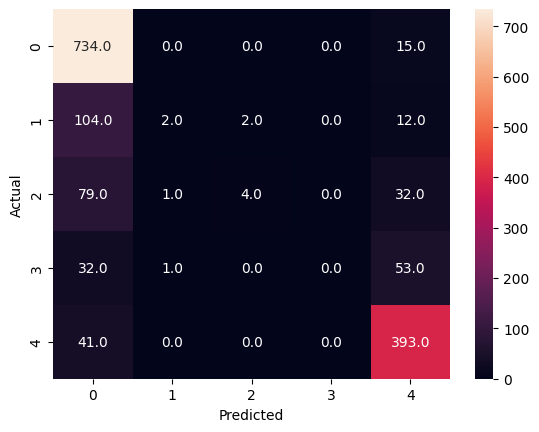

In [62]:
sns.heatmap(confusion_matrix(test_target,target_predicted), annot=True, fmt='.1f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

По представлению тепловой карты можно сделать вывод, что негативные отзывы (оценка 1, на карте оценка 0) определяются лучше остальных. Положительные (5, на карте 4) тоже имеют хороший показатель

Матрица ошибок для сбалансированного леса

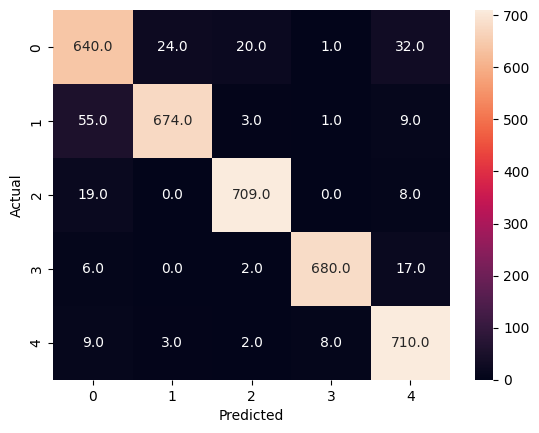

In [63]:
sns.heatmap(confusion_matrix(test_target_tfidf,target_predicted_tfidf), annot=True, fmt='.1f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Все отзывы практически в равной мере определяются

**Вывод**: в ходе данной лабораторной работы была произведена предобработка данных, очистка, балансировка классов, приведение текстовых данных к верторному представлению. Впоследствии были применены модели машинного обучения, как для сбалансированных данных, так и для дисбалансных. Для каждой модели была отображена ее точность (accuracy) и время выполнения. В результате данной практической работы мной были отточены навыки процессинга текста на естественных языках и некоторые моменты машинного обучения. Исходя из полученного датафрейма метрик производительности определения рейтинга отзыва лучше всех показала себя модель `RandomForest` с `accuracy = 0.94`.

Впоследствии будет производиться работа над ошибками и совершенствание навыков работы с NLP

# Дополнительное задание

Генерация вручную новых отзывов

In [81]:
new_sentences = ['Wow! Their product are outstanding! First class, great quality. Already recommended them to my friends. I want to order one more time.',
                 'I was not satisfied with their service! Everything was done horribly.',
                 'Thought they were better! On the photos they are depicted better than in reality, do not correspond with the description.',
                 'Ordered them last weekend and they have already arrived. What an operative work, excellent.',
                 'Cannot say any other words but thank you for your product! I am delighted, they are fantastic.',
                 'Quality is horrible! Knitting is awful, could be much better.',
                 'Not satisfied with the customer management service. Waited for the answer too long, poor client connection',
                 'Well, some moments were good, some points were bad. They are ok. Nevertheless, the print is awesome.',
                 'Honestly speaaking, i thought the product would be better. There are a lot of defects, i am frustrated. I want my refund for that product',
                 'The best socks i have ever worn. So funny, so soft, are suitable for a gift. Glad the company generated such an idea.']
processed_new_sentences = [' '.join(preprocessed(each)) for each in new_sentences]

In [82]:
processed_new_sentences

['product outstanding first class great quality already recommend friend want order time',
 'satisfied service everything do horribly',
 'think well photo depict well reality correspond description',
 'order last weekend already arrive operative work excellent',
 'say word thank product delight fantastic',
 'quality horrible knitting awful much well',
 'satisfied customer management service wait answer long poor client connection',
 'moment good point bad nevertheless print awesome',
 'honestly speaake thought product well lot defect frustrate want refund product',
 'good sock ever wear funny soft suitable gift glad company generate idea']

Подгрузка файла (объекта) векторизации новых отзывов, чтобы сопоставить их с векторизацией модели до обучения

In [83]:
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
new_tfidf_vectors = tfidf_vectorizer.transform(processed_new_sentences)
new_predictions = rf.predict(new_tfidf_vectors)

print('Predictions:')
for each in list(zip(new_sentences, new_predictions)):
    print(each)

Predictions:
('Wow! Their product are outstanding! First class, great quality. Already recommended them to my friends. I want to order one more time.', '5')
('I was not satisfied with their service! Everything was done horribly.', '1')
('Thought they were better! On the photos they are depicted better than in reality, do not correspond with the description.', '5')
('Ordered them last weekend and they have already arrived. What an operative work, excellent.', '1')
('Cannot say any other words but thank you for your product! I am delighted, they are fantastic.', '5')
('Quality is horrible! Knitting is awful, could be much better.', '1')
('Not satisfied with the customer management service. Waited for the answer too long, poor client connection', '1')
('Well, some moments were good, some points were bad. They are ok. Nevertheless, the print is awesome.', '5')
('Honestly speaaking, i thought the product would be better. There are a lot of defects, i am frustrated. I want my refund for that

**Вывод**: с помощью модели машинного обучения `RandomForestClassifier`, данные для которой были отвекторизованы с помощью `TF-IDF`, а классы их сбалансированы с помощью `SMOTE`, было произведено тестирование модели на новых отзывах. Оценки в основном либо твердо положительные, либо твердо отрицательные, что и было отображено при составлении матрицы ошибок (модель лучше себя показывает на оценках "очень плохо" или "отлично"). В результате предсказания *8 из 10 оценок были определены корректно*, что не может не радовать. Считаю, что в дальнейшем после некоторых поправок, доработки и усовершенствования модели машинного обучения она будет показывать себя еще лучше.